## Read dataset

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import keras
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
from PIL import ImageOps
from PIL import Image 

In [2]:
input_dat = np.load(os.path.join('train_input_dat.npy'))
target_dat = np.load(os.path.join('train_target_dat.npy'))

In [3]:
train_input_dat=input_dat[1500:,:,:,:]
train_target_dat=target_dat[1500:,:,:,:]

val_input_dat=input_dat[:1500,:,:,:]
val_target_dat=target_dat[:1500,:,:,:]



## Perpare U-Net Xception-style model

In [4]:

img_size = (224, 224)
num_classes = 9
batch_size = 32

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
num_classes=9
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

https://keras.io/api/metrics/segmentation_metrics/#image-segmentation-metrics

## Train

In [5]:
#Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
  
#  


model.compile(
  optimizer='sgd',
  loss='mse',
  metrics=[tf.keras.metrics.CategoricalCrossentropy()]
)


callbacks = [
    keras.callbacks.ModelCheckpoint("satellite_segmentation-v001.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
history=model.fit(train_input_dat, train_target_dat, epochs=epochs, validation_data=(val_input_dat,val_target_dat), callbacks=callbacks)

Epoch 1/100
115/115 [==============================] - 219s 2s/step - loss: 0.1206 - categorical_crossentropy: 4.5476 - val_loss: 0.1286 - val_categorical_crossentropy: 3.2323
Epoch 2/100
115/115 [==============================] - 38s 333ms/step - loss: 0.1025 - categorical_crossentropy: 3.4313 - val_loss: 0.1683 - val_categorical_crossentropy: 4.9563
Epoch 3/100
115/115 [==============================] - 37s 323ms/step - loss: 0.0956 - categorical_crossentropy: 3.1286 - val_loss: 0.1753 - val_categorical_crossentropy: 5.5606
Epoch 4/100
115/115 [==============================] - 37s 324ms/step - loss: 0.0924 - categorical_crossentropy: 2.9913 - val_loss: 0.1543 - val_categorical_crossentropy: 4.0161
Epoch 5/100
115/115 [==============================] - 37s 326ms/step - loss: 0.0902 - categorical_crossentropy: 2.8699 - val_loss: 0.0894 - val_categorical_crossentropy: 2.2201
Epoch 6/100
115/115 [==============================] - 38s 328ms/step - loss: 0.0882 - categorical_crossentropy:

115/115 [==============================] - 38s 328ms/step - loss: 0.0667 - categorical_crossentropy: 1.4531 - val_loss: 0.0620 - val_categorical_crossentropy: 1.3643
Epoch 46/100
115/115 [==============================] - 38s 328ms/step - loss: 0.0665 - categorical_crossentropy: 1.4422 - val_loss: 0.0623 - val_categorical_crossentropy: 1.3606
Epoch 47/100
115/115 [==============================] - 38s 329ms/step - loss: 0.0663 - categorical_crossentropy: 1.4358 - val_loss: 0.0619 - val_categorical_crossentropy: 1.3492
Epoch 48/100
115/115 [==============================] - 38s 327ms/step - loss: 0.0663 - categorical_crossentropy: 1.4335 - val_loss: 0.0620 - val_categorical_crossentropy: 1.3545
Epoch 49/100
115/115 [==============================] - 38s 327ms/step - loss: 0.0663 - categorical_crossentropy: 1.4289 - val_loss: 0.0614 - val_categorical_crossentropy: 1.3375
Epoch 50/100
115/115 [==============================] - 38s 327ms/step - loss: 0.0659 - categorical_crossentropy: 1.41

Epoch 91/100
115/115 [==============================] - 38s 330ms/step - loss: 0.0626 - categorical_crossentropy: 1.3084 - val_loss: 0.0579 - val_categorical_crossentropy: 1.2186
Epoch 92/100
115/115 [==============================] - 37s 326ms/step - loss: 0.0627 - categorical_crossentropy: 1.3100 - val_loss: 0.0589 - val_categorical_crossentropy: 1.2432
Epoch 93/100
115/115 [==============================] - 38s 327ms/step - loss: 0.0625 - categorical_crossentropy: 1.3065 - val_loss: 0.0579 - val_categorical_crossentropy: 1.2140
Epoch 94/100
115/115 [==============================] - 38s 327ms/step - loss: 0.0626 - categorical_crossentropy: 1.3073 - val_loss: 0.0579 - val_categorical_crossentropy: 1.2155
Epoch 95/100
115/115 [==============================] - 37s 326ms/step - loss: 0.0625 - categorical_crossentropy: 1.3038 - val_loss: 0.0582 - val_categorical_crossentropy: 1.2186
Epoch 96/100
115/115 [==============================] - 38s 328ms/step - loss: 0.0626 - categorical_cross

In [6]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [7]:
df=pd.read_csv('history.csv')
df

,Unnamed: 0,loss,categorical_crossentropy,val_loss,val_categorical_crossentropy
0,0,0.120558,4.547595,0.128613,3.232262
1,1,0.102537,3.431288,0.168251,4.956266
2,2,0.095637,3.128573,0.175250,5.560576
3,3,0.092387,2.991292,0.154256,4.016066
4,4,0.090175,2.869921,0.089397,2.220133
...,...,...,...,...,...
95,95,0.062590,1.305532,0.057709,1.214317
96,96,0.062421,1.302096,0.057592,1.208156
97,97,0.062437,1.303196,0.057742,1.212654
98,98,0.062339,1.299611,0.057545,1.205265


## Evaluate model

## Visualizing model performance
### Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

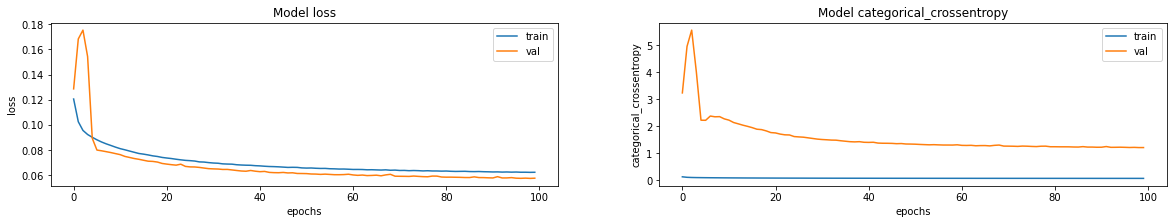

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'categorical_crossentropy']):
    ax[i].plot(df['loss'])
    ax[i].plot(df["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Confution matrix

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

In [9]:
Y_pred = model.predict_generator((val_input_dat,val_target_dat), 1500 // batch_size+1)
y_pred= np.argmax(Y_pred, axis=3).flatten()
y= np.argmax(val_target_dat, axis=3).flatten()


Instructions for updating:
Please use Model.predict, which supports generators.


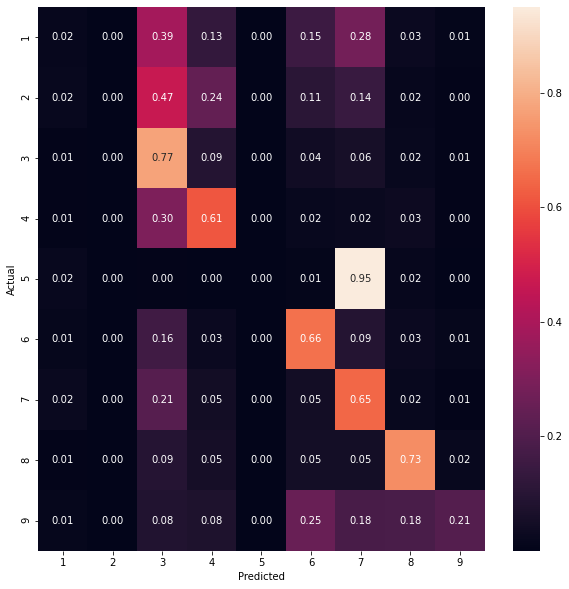

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(y, y_pred)
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Model Evaluate

## Visualize predictions

In [11]:
Y_pred.shape

(1500, 224, 224, 9)

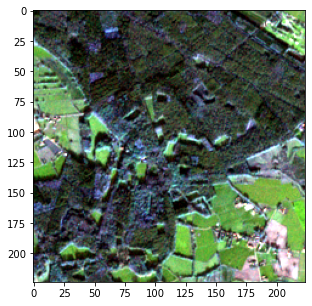

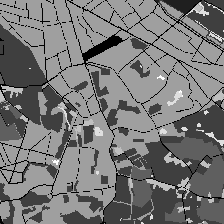

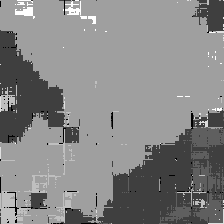

In [55]:
# Generate predictions for all images in the validation set


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(Y_pred[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
def display_target(i):
    mask = np.argmax(val_target_dat[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    
def display_val(i):
    I=val_input_dat
    tmp = np.zeros((I.shape[1], I.shape[2], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[i,:,:,q])
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(5, 5)
    plt.show()
    
# Display results for validation image #10
i = 12

# Display input image
display_val(i)

# Display ground-truth target mask
display_target(i)
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

